In [2]:
from models.model import ImagenTime # \models\model.py
from utils.utils_data import gen_dataloader
from utils.utils import restore_state
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from models.sampler import DiffusionProcess
%matplotlib inline
import torch




In [6]:

# Define args as needed for gen_dataloader
class Args:
	def __init__(self):
		self.batch_size = 69696 # check this 
		self.shuffle = True
			
		self.dataset = "fmri"    
		self.device = "cuda"
		self.use_stft = True
		self.diffusion_steps = 18
		self.n_fft = 63
		self.hop_length = 8
		self.img_resolution = 32
		
		self.input_channels = 2
		self.unet_channels = 128
		self.ch_mult = [1,2,4,4]
		self.attn_resolution = [32,16,8]
		self.ema = True
		self.ema_warmup = 100
		self.logging_iter = 100
		self.learning_rate: 0.0003 #1e-4
		self.weight_decay: 0.00001 #1e-5
		self.num_workers = 4
# 


args = Args()
train_loader, test_loader = gen_dataloader(args)
print("dataset ready")

./data/short_range/padded_fmri_set.pt
dataset ready


In [7]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args.device = device

model = ImagenTime(args=args, device=args.device).to(args.device)
if args.use_stft:
    model.init_stft_embedder(train_loader)
    print("STFT embedder initialized")

args.learning_rate=  0.0003 #1e-4
args.weight_decay=  0.00001 #1e-4
args.resume = False
args.epochs = 1000
args.beta1 = 1e-05
args.betaT = 0.01
args.deterministic = False




optimizer = torch.optim.AdamW(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)
state = dict(model=model, epoch=0)
init_epoch = 0


if args.resume:
    ema_model = model.model_ema if args.ema else None # load ema model if available
    init_epoch = restore_state(args, state, ema_model=ema_model)

STFT embedder initialized


x_ts shape:  torch.Size([140, 264, 1])
real shape: torch.Size([140, 1, 32, 32])
imag shape: torch.Size([140, 1, 32, 32])
torch.Size([140, 2, 32, 32])


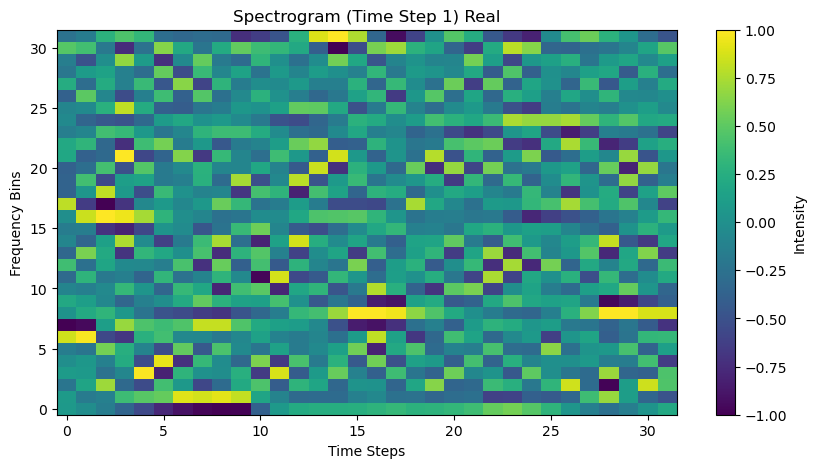

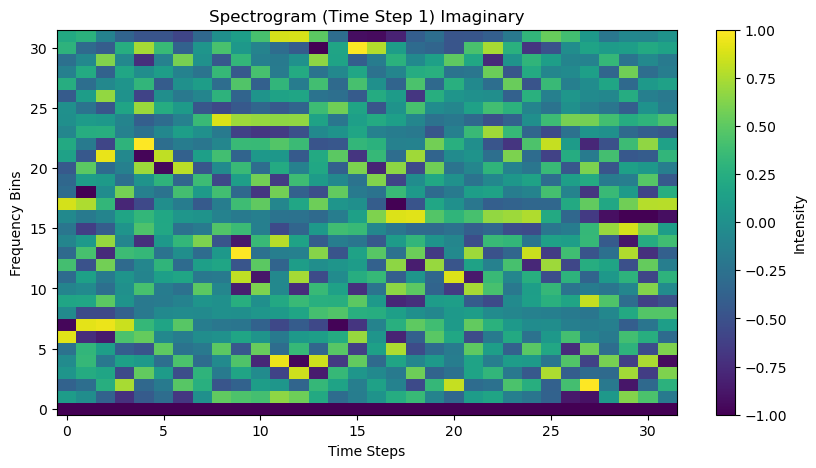

In [11]:
for i, data in enumerate(train_loader, 1):
    x_ts = data[0].to(args.device)
    print("x_ts shape: ", x_ts.shape)

    x_img = model.ts_to_img(x_ts)
    print(x_img.shape)

    img_sample = x_img[0, 0, :, :]  # taking real part

    img_numpy = img_sample.cpu().detach().numpy()

    # Plot the spectrogram
    plt.figure(figsize=(10, 5))
    plt.imshow(img_numpy, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label='Intensity')
    plt.title("Spectrogram (Time Step 1) Real")
    plt.xlabel("Time Steps")
    plt.ylabel("Frequency Bins")
    plt.savefig('spectrogram_fmri_Real.png')
    plt.show()


    img_sample = x_img[0, 1, :, :]  # taking imag part

    img_numpy = img_sample.cpu().detach().numpy()
    
    # Plot the spectrogram
    plt.figure(figsize=(10, 5))
    plt.imshow(img_numpy, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label='Intensity')
    plt.title("Spectrogram (Time Step 1) Imaginary")
    plt.xlabel("Time Steps")
    plt.ylabel("Frequency Bins")
    plt.savefig('spectrogram_fmri_Imag.png')
    plt.show()

    break





In [13]:
orig_ts = model.img_to_ts(x_img)
print("\n")

print(orig_ts.shape)

real shape: torch.Size([140, 1, 32, 32])
imag shape: torch.Size([140, 1, 32, 32])
max_real shape: torch.Size([1, 32, 32])
min_real shape: torch.Size([1, 32, 32])


torch.Size([140, 264, 1])


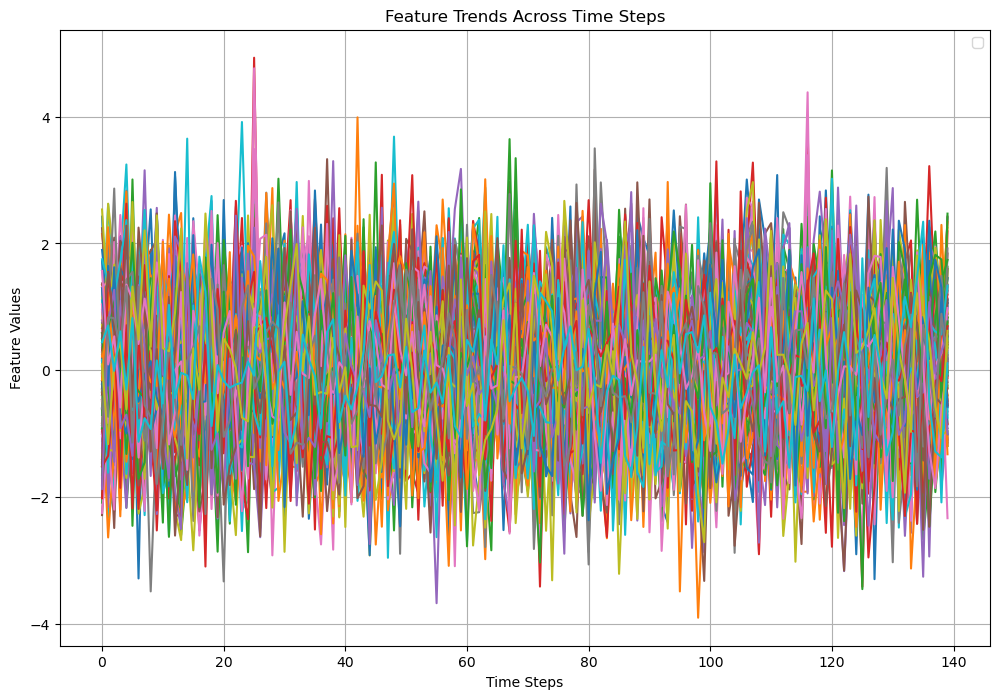

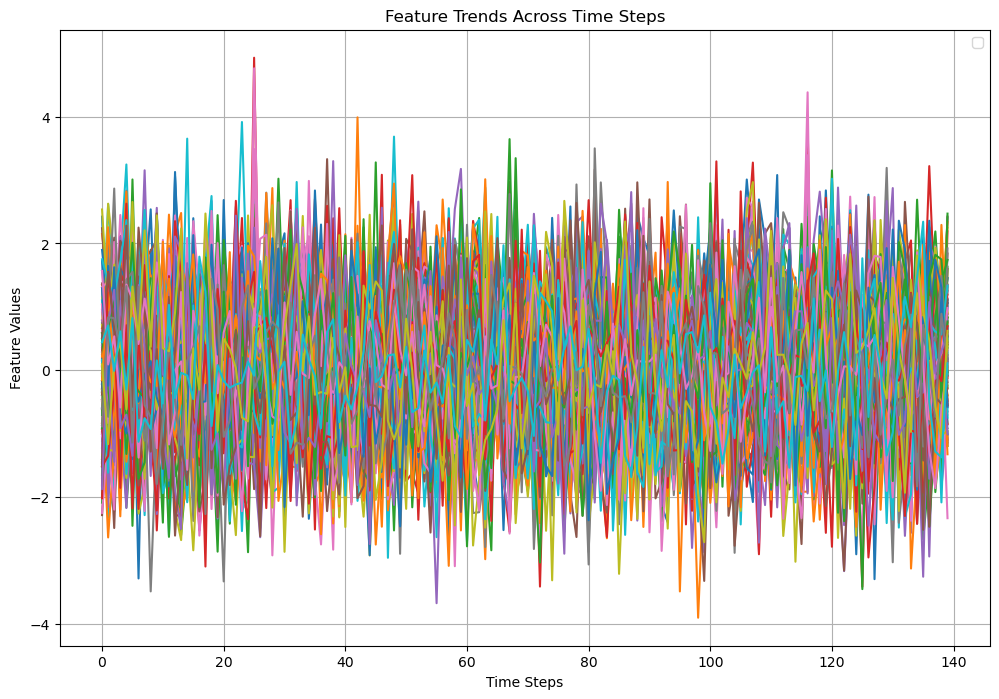

In [30]:
# Code for Time Series Before & After Model 

data = orig_ts.squeeze(-1).numpy()  # Remove the last dimension to get shape (140, 264)

# Plot a subset of features for clarity
num_features_to_plot = len(data)  # Number of features to visualize
plt.figure(figsize=(12, 8))

for i in range(num_features_to_plot):
    plt.plot(data[:, i])

plt.title("Feature Trends Across Time Steps")
plt.xlabel("Time Steps")
plt.ylabel("Feature Values")
plt.legend()
plt.grid(True)
# plt.savefig('TimeSeries_After_trans.png')
plt.show()



data = x_ts.squeeze(-1).numpy()  # Remove the last dimension to get shape (140, 264)

num_features_to_plot = len(data)  #
plt.figure(figsize=(12, 8))

for i in range(num_features_to_plot):
    plt.plot(data[:, i])

plt.title("Feature Trends Across Time Steps")
plt.xlabel("Time Steps")
plt.ylabel("Feature Values")
plt.legend()
plt.grid(True)
# plt.savefig('TimeSeries_Before_trans.png')
plt.show()

ts_after_model = orig_ts


In [31]:
Bf_transform_ts = x_ts
After_trans_ts = ts_after_model


print(f"Before Transformation ts_shape: {Bf_transform_ts.shape}")
print(f"After Transformation ts_shape: {After_trans_ts.shape}")
print("\n")

# Flatten the tensors to 1D for calculation
Bf_transform_ts_flat = Bf_transform_ts.view(-1)
After_trans_ts_flat = After_trans_ts.view(-1)

# Calculate MAE (Mean Absolute Error)
mae = torch.mean(torch.abs(Bf_transform_ts_flat - After_trans_ts_flat))

# Calculate MRSE (Mean Root Squared Error)
mrse = torch.sqrt(torch.mean((Bf_transform_ts_flat - After_trans_ts_flat) ** 2))

print(f"MAE: {mae.item()}")
print(f"MRSE: {mrse.item()}")

Before Transformation ts_shape: torch.Size([140, 264, 1])
After Transformation ts_shape: torch.Size([140, 264, 1])


MAE: 6.912443240025823e-08
MRSE: 9.96346898318734e-08
